In [1]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from src.configs import BallEncoder, BallDecoder, BallTransition
from src.e2c import E2C

### Method to create (3,32,32) tensor

In [2]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [3]:
def step(x0, Ak, add_noise=False):
    # If ball in left-half plane, flip sign of vx
    if x0[0] < 0.5*posbounds[1]:
        x0[2] *= -1.

    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [4]:
n = 4 
dh = 0.1

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32
NUM_DATA = 50

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

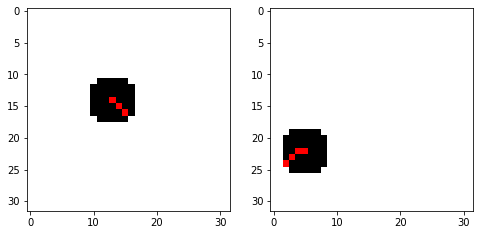

In [12]:
idx = 40
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [6]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0

In [7]:
model = E2C(dim_in, dim_z, dim_u, config='cifar')
inp = torch.from_numpy(X[:2]).float()

mean, logvar = model.encode(inp)

In [8]:
model.decode(mean).shape

torch.Size([2, 3, 32, 32])

## Training loop

In [9]:
before = torch.from_numpy(X[:1]).float()
after = torch.from_numpy(X_next[:1]).float()

ctrl = torch.from_numpy(np.empty((NUM_DATA,0))).float()
ctrl = torch.tensor([])
ctrl = torch.empty(NUM_DATA, dim_u)

# model.forward(before, ctrl, after)

In [10]:
# criterion = nn.MSELoss()
# optimizer = optim.Adam(e2c.parameters(), lr=1e-4)

# # training parameters
# TRAINING_ITERATIONS = int(100)
# BATCH_SIZE = 32
# CHECKPOINT_AFTER = int(10)
# SAVEPOINT_AFTER = int(20)
# TEST_BATCH_SIZE = int(200)

# rand_idx = list(np.arange(0, X_train.shape[0]-1))
# indices = [rand_idx[ii * BATCH_SIZE:(ii + 1) * BATCH_SIZE] \
#     for ii in range((len(rand_idx) + BATCH_SIZE - 1)     // BATCH_SIZE)]

# for epoch in range(TRAINING_ITERATIONS):
#     for ii, idx in enumerate(indices):
#         optimizer.zero_grad()

#         next_pre_rec = model(x, action, x_next)
#         loss_rec, loss_trans = model.compute_loss(\
#             model.x_dec, model.x_next_pred_dec, \
#             x, x_next, \
#             model.Qz, model.Qz_next_pred, model.Qz_nex, mse=False)
        
#         ll = latent_loss(vae.z_mean, vae.z_sigma)
#         loss = criterion(dec, inputs) + ll
#         loss.backward()
#         optimizer.step()

In [11]:
# from IPython import display
# import matplotlib.pyplot as plt

# %matplotlib inline

# import gym
# from gym import wrappers

# env = gym.make('CartPole-v0')
# # env = wrappers.Monitor(env, "./gym-results", force=True)
# env.reset()

# # plt.figure(figsize=(9,9))
# # img = plt.imshow(env.render(mode='rgb_array')) # only call this once

# for _ in range(10):
# #     img.set_data(env.render(mode='rgb_array')) # just update the data
# #     display.display(plt.gcf())
# #     display.clear_output(wait=True)

#     obs, reward, done, info = env.step(env.action_space.sample())
# #     env.render()
#     if done:
#         env.reset()

# env.close()